# Multicamera Point Cloud fusion

## Usage
* requires 
    * calibration.json from collect_data_and_cal.py
    * rgbd image capture
* conda activate eyehandcal
* pip install jupyter; jupyter notebook
* Run this notebook inside jupyter

In [1]:
#save inline outputs in jpeg to minimize ipynb size (10x reduction from default pngs)
%matplotlib inline
%config InlineBackend.figure_format = 'jpeg'

import json
import sophus as sp
from fairotag.scene import SceneViz
import numpy as np
from eyehandcal.utils import rotmat

In [2]:
with open('calibration.json') as f:
    calibration = json.load(f)

# print(json.dumps(calibration, indent=4))

## Load data from file or live capture

In [1]:
import pickle, os
rgbd_capture_path = '/tmp/rgbd_capture.pkl'
try:
    with open(rgbd_capture_path, 'rb') as f:
            rgbd_capture = pickle.load(f)
    frameset = rgbd_capture['frameset']
    intrinsics = rgbd_capture['intrinsics']
except Exception as e:
    print(e)
    from realsense_wrapper import RealsenseAPI
    api = RealsenseAPI(depth_preset='High Accuracy')
    frameset=api.get_rgbd()
    intrinsics=api.get_intrinsics_dict()
    with open(rgbd_capture_path, 'wb') as f:
        pickle.dump({'frameset':frameset, 'intrinsics': intrinsics}, f)
    del api #relesae camera



[Errno 2] No such file or directory: '/tmp/rgbd_capture.pkl'
Connecting to RealSense cameras (3 found) ...
High Accuracy  preset is: 3
Connected to camera 1 (143422072110).
High Accuracy  preset is: 3
Connected to camera 2 (207522071445).
High Accuracy  preset is: 3
Connected to camera 3 (817612070939).


## Show depth image quality

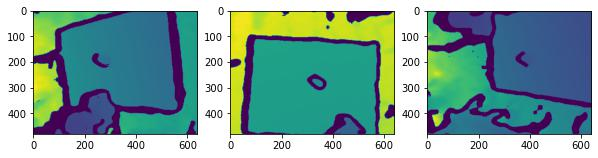

In [4]:
import matplotlib.pylab as plt
    
plt.figure(figsize=(10,3))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(frameset[i,:,:,3])

In [5]:

def pointcloud(rgbd, intr):
    # print(rgbd.shape,intr)
    xs, ys = np.meshgrid(np.arange(intr['width']), np.arange(intr['height']))
    z=rgbd[:,:,3]/1000.
    xyz=np.stack([
        (xs - intr['ppx'])/intr['fx']*z, 
        (ys - intr['ppy'])/intr['fy']*z,
        z,
    ],
    axis=0)
    xyz[2][xyz[2]==0] = np.nan #remove invalid depths
    return xyz.reshape(3,-1)

#unit-test
xyz=pointcloud(frameset[0], list(intrinsics.values())[0])

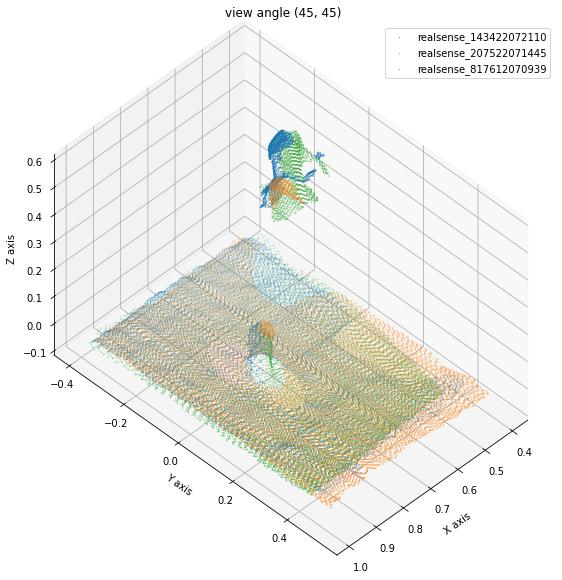

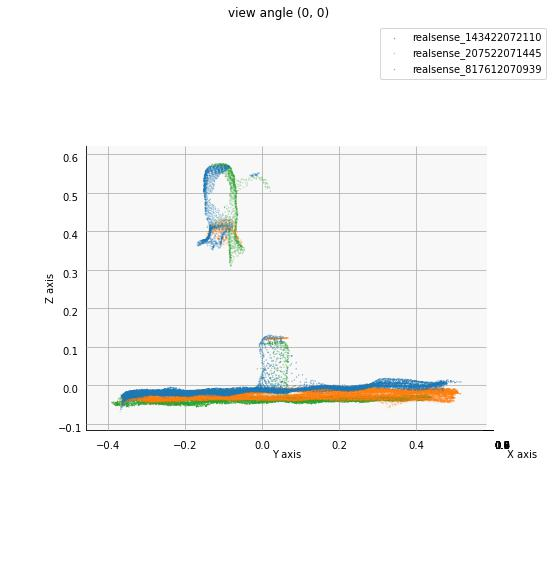

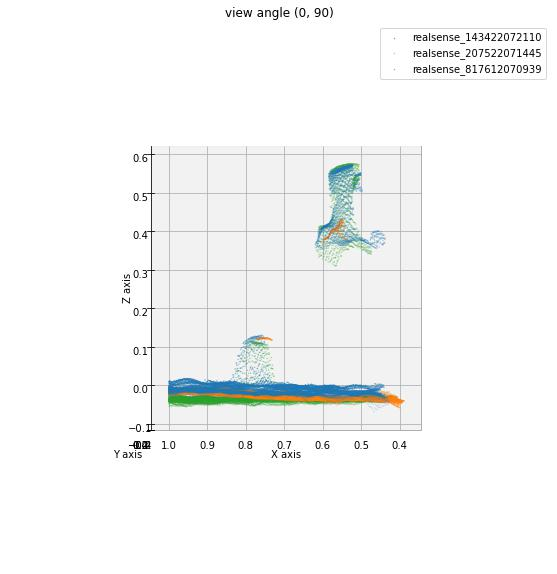

In [6]:
import sophus as sp


for viewangle in [(45,45), (0,0), (0, 90)]:
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d', proj_type='ortho')
    cmap=plt.cm.jet(3)
    for i in range(3):
        xyz=pointcloud(frameset[i], list(intrinsics.values())[0])
        transform=sp.SE3(sp.SO3.exp(calibration[i]['camera_base_ori_rotvec']).matrix(),     
                         calibration[i]['camera_base_pos'])
        xyz = transform.matrix3x4() @ np.vstack([xyz, np.ones(xyz.shape[1])])
        xyz=xyz[:, np.all(np.vstack([
                                      xyz[0,:]<1.0,   #show things close to robot
                                      xyz[2,:]>-0.2,  #show only things above table
                                    ]),
                                  axis=0)] #remove sub zero points
        xyz=xyz[:, ::9]
        ax.scatter3D(*xyz, s=.1)

    ax.legend([f"realsense_{c['camera_serial_number']}" for c in calibration])
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_box_aspect([np.ptp(ax.get_xlim()), np.ptp(ax.get_ylim()), np.ptp(ax.get_zlim())])
    ax.view_init(*viewangle)
    ax.set_title(f'view angle {viewangle}') 

